In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, math, datetime
from pprint import pformat
from graphviz import Digraph
from itertools import combinations
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import hmms
import os
import math

In [2]:
# Configuration parameters
N_nodes = 81
random_state = 2
val_size = 1/3
K = 3
rejection_negative_bias = 2

rejections_trained = True
# baum_welch = True
# bw_epochs = 10

# Observation matrix params
prob_emission_equals_hidden = 0.95

prob_emission_not_equals_hidden = 1 - prob_emission_equals_hidden

#Trans prob matrix params
trans_prob_factor = 100
rejection_trans_prob_factor = 1

#Init prob matrix params
init_prob_factor = 100
rejection_init_prob_factor = 1

In [3]:
# Load validation QTC_C sequences (recorded in lab)
rotl_lab_seqs = []
rotr_lab_seqs = []
pb_l_lab_seqs = []
pb_r_lab_seqs = []
pc_lab_seqs = []
u_lab_seqs = []
u_lab_seqs_no_train = []

with open("lab_qtc_seqs.pickle", "rb") as f:
    lab_seqs = pickle.load(f)
lab_seqs

{'u_h_meets_stationary_r_3': ['0-0-',
  '0+0-',
  '0-0+',
  '000+',
  '0000',
  '000+',
  '0-0+',
  '000+'],
 'ot_hotr_12': ['+-0+', '+--+', '++--'],
 'u_h_pb_l_robot_stationary_6': ['0-0-',
  '000-',
  '0+0-',
  '0+0+',
  '0+0-',
  '0+0+',
  '0+0-'],
 'u_h_pb_l_robot_stationary_8': ['0-0-', '0+0-', '0+0+', '0+00'],
 'ot_hotl_6': ['+-+0',
  '+-+-',
  '+-+0',
  '+-++',
  '+-0+',
  '+--+',
  '+0-+',
  '+---',
  '++--',
  '++-+',
  '++--'],
 'u_h_and_r_stationary_6': ['0000'],
 'u_h_pb_l_robot_stationary_7': ['0-0-', '000-', '0+0-', '0+0+', '0+0-'],
 'u_h_meets_stationary_r_5': ['0-0-',
  '0-00',
  '000+',
  '0+0+',
  '000+',
  '0000',
  '000+',
  '0000'],
 'u_r_meets_stationary_h_3': ['0---', '00--', '+0--', '+---'],
 'ot_rotl_33': ['+0--',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '+---',
  '++--',
  '+0--',
  '++--',
  '+00-',
  '+-00',
  '+000',
  '+-0+',
  '0-0+'],
 'ot_rotr_7': ['+000',
  '+00+',
  '+0-0',
  '++-0',
  '++-+',
  '++0+

In [4]:
for key in lab_seqs.keys():
    if key.split("_")[0] == "u":
        print(key)

u_h_meets_stationary_r_3
u_h_pb_l_robot_stationary_6
u_h_pb_l_robot_stationary_8
u_h_and_r_stationary_6
u_h_pb_l_robot_stationary_7
u_h_meets_stationary_r_5
u_r_meets_stationary_h_3
u_r_meets_stationary_h_13
u_h_pb_r_robot_stationary_1
u_h_pb_r_robot_stationary_2
u_h_pb_r_robot_stationary_3
u_h_pb_r_robot_stationary_6
u_h_pb_r_robot_stationary_7
u_h_pb_r_robot_stationary_4
u_h_pb_r_robot_stationary_5
u_r_meets_stationary_h_12
u_h_and_r_stationary_10
u_h_and_r_stationary_12
u_h_pb_r_robot_stationary_8
u_h_meets_stationary_r_12
u_h_meets_stationary_r_13
u_h_meets_stationary_r_10
u_h_meets_stationary_r_11
u_h_meets_stationary_r_14
u_h_meets_stationary_r_15
u_h_and_r_stationary_9
u_h_meets_stationary_r_6
u_h_meets_stationary_r_7
u_h_pb_l_robot_stationary_12
u_h_and_r_stationary_8
u_r_meets_stationary_h_10
u_h_meets_stationary_r_4
u_r_meets_stationary_h_2
u_h_pb_l_robot_stationary_15
u_h_and_r_stationary_7
u_h_pb_l_robot_stationary_13
u_h_pb_r_robot_stationary_9
u_h_pb_r_robot_stationary_14

In [5]:
for key in lab_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[1] == "rotl":
        rotl_lab_seqs.append(lab_seqs[key])
    elif key.split("_")[1] == "rotr":
        rotr_lab_seqs.append(lab_seqs[key])
    elif class_code == "pb":
        if key.split("_")[1] == "l":
            pb_l_lab_seqs.append(lab_seqs[key])
        else:
            pb_r_lab_seqs.append(lab_seqs[key])
    elif class_code == "pc":
        pc_lab_seqs.append(lab_seqs[key])
#     elif "u_r_meets" in key or "u_h_meets" in key:
#         u_lab_seqs_no_train.append(lab_seqs[key])
    else:
        u_lab_seqs.append(lab_seqs[key])
        
print(len(rotl_lab_seqs))
print(len(rotr_lab_seqs))
print(len(pb_l_lab_seqs))
print(len(pb_r_lab_seqs))
print(len(pc_lab_seqs))
print(len(u_lab_seqs))
print(len(u_lab_seqs_no_train))

35
35
35
35
70
105
0


In [6]:
rotl_lab_seqs_train, rotl_lab_seqs_val = train_test_split(rotl_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(rotl_lab_seqs_train))
print(len(rotl_lab_seqs_val))

23
12


In [7]:
rotr_lab_seqs_train, rotr_lab_seqs_val = train_test_split(rotr_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(rotr_lab_seqs_train))
print(len(rotr_lab_seqs_val))

23
12


In [8]:
pb_l_lab_seqs_train, pb_l_lab_seqs_val = train_test_split(pb_l_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(pb_l_lab_seqs_train))
print(len(pb_l_lab_seqs_val))

23
12


In [9]:
pb_r_lab_seqs_train, pb_r_lab_seqs_val = train_test_split(pb_r_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(pb_r_lab_seqs_train))
print(len(pb_r_lab_seqs_val))

23
12


In [10]:
pc_lab_seqs_train, pc_lab_seqs_val = train_test_split(pc_lab_seqs, 
    test_size=val_size,
    random_state=random_state)
print(len(pc_lab_seqs_train))
print(len(pc_lab_seqs_val))

46
24


In [11]:
u_lab_seqs_train, u_lab_seqs_val = train_test_split(u_lab_seqs, test_size=val_size, random_state=random_state)
for seq in u_lab_seqs_no_train:
    u_lab_seqs_val.append(seq)
print(len(u_lab_seqs_train))
print(len(u_lab_seqs_val))

70
35


In [12]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [13]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [14]:
# Defining a uniform transition matrix of N_nodes states
uniform_trans_mat = np.zeros((N_nodes, N_nodes))
uniform_trans_mat = np.array([[1/N_nodes for trans in row] for row in uniform_trans_mat])
print("\n", uniform_trans_mat)
row_sums = []
for row in uniform_trans_mat:
    row_sums.append(np.sum(row))
print(np.mean(row_sums))


 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0


In [15]:
def draw_transition_matrix(trans_matrix, filename, min_trans_prob):
    # draw its transition matrix
    dot = Digraph(comment='HMM model')
    col, row = trans_matrix.shape
    for i in range(0, col):
        for j in range(0, row):
#             print(i, j, trans_matrix[i, j])
            if trans_matrix[i, j] >= min_trans_prob:
#                 print(i, j, "is a high probability transition")
                dot.edge(num_to_QTC_C(i), num_to_QTC_C(j), label='{:2.2f}'.format(trans_matrix[i, j]))

    dot.render(filename, view=True)

## Creating pass-by left HMM

In [16]:
pass_by_l_seqs = pb_l_lab_seqs_train

In [17]:
pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
print(pass_by_l_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

[[30], [30, 40, 57, 30, 40, 30, 40], [13, 4], [4, 7, 1, 10], [30], [57, 30, 40, 57, 30, 40, 57, 30, 31, 40, 67], [30, 40, 30, 40, 30], [13, 4, 7], [40, 31, 67, 76, 58, 4], [31, 58, 4], [57, 30], [40, 67, 76, 4, 13, 12], [40, 67, 13, 4, 7, 1], [40, 67, 76, 4], [30, 40, 75, 57, 30], [67, 13, 22, 4, 13, 16, 10], [30, 40, 21, 3, 57, 30], [39, 40, 67, 13, 4, 7, 1, 0], [40, 67, 58, 4], [40, 67, 76, 4], [30], [67, 22, 4, 16, 10], [49, 58, 4, 7, 16, 10]]


[['-+-+'],
 ['-+-+', '----', '0+-+', '-+-+', '----', '-+-+', '----'],
 ['+---', '++--'],
 ['++--', '++0-', '+++-', '+-+-'],
 ['-+-+'],
 ['0+-+',
  '-+-+',
  '----',
  '0+-+',
  '-+-+',
  '----',
  '0+-+',
  '-+-+',
  '-+--',
  '----',
  '0---'],
 ['-+-+', '----', '-+-+', '----', '-+-+'],
 ['+---', '++--', '++0-'],
 ['----', '-+--', '0---', '00--', '0+--', '++--'],
 ['-+--', '0+--', '++--'],
 ['0+-+', '-+-+'],
 ['----', '0---', '00--', '++--', '+---', '+--+'],
 ['----', '0---', '+---', '++--', '++0-', '+++-'],
 ['----', '0---', '00--', '++--'],
 ['-+-+', '----', '00-+', '0+-+', '-+-+'],
 ['0---', '+---', '+0--', '++--', '+---', '+-0-', '+-+-'],
 ['-+-+', '----', '+0-+', '++-+', '0+-+', '-+-+'],
 ['---+', '----', '0---', '+---', '++--', '++0-', '+++-', '++++'],
 ['----', '0---', '0+--', '++--'],
 ['----', '0---', '00--', '++--'],
 ['-+-+'],
 ['0---', '+0--', '++--', '+-0-', '+-+-'],
 ['-0--', '0+--', '++--', '++0-', '+-0-', '+-+-']]

In [18]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_l_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
0
0
1
2
0
1
2
3
4
5
6
7
8
9
0
1
2
3
0
1
0
1
2
3
4
0
1
0
0
1
2
3
4
0
1
2
3
4
0
1
2
0
1
2
3
0
1
2
3
4
5
0
1
2
3
4
0
1
2
3
4
5
6
0
1
2
0
1
2
0
1
2
3
0
1
2
3
4
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.3594306  0.00355872 0.00355872 ... 0.00355872 0.00355872 0.00355872]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]


In [19]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_l_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pblHMM = hmms.DtHMM(A, B, Pi)

# Check pblHMM params
A, B, Pi = pblHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.3594306  0.00355872 0.00355872 ... 0.00355872 0.00355872 0.00355872]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [20]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Left_Lab_Egs_Transitions", 0.013)

Pass-by left HMM:


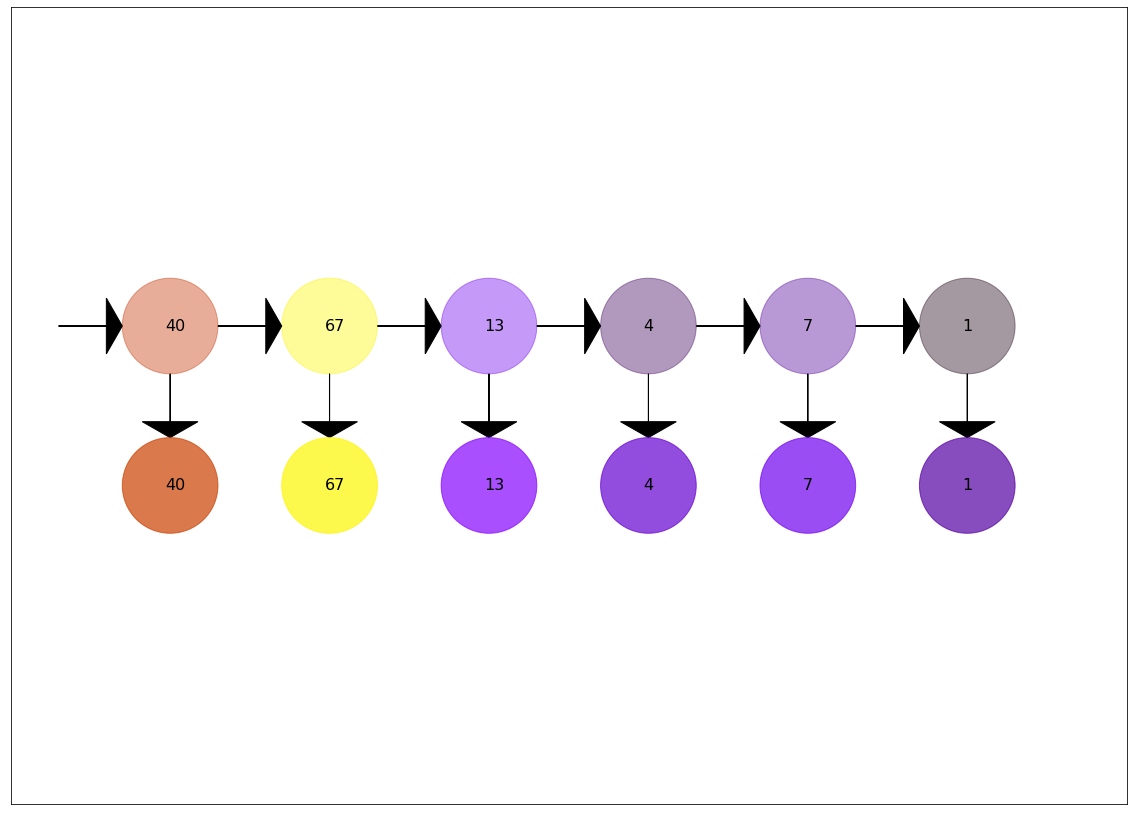

['----', '0---', '+---', '++--', '++0-', '+++-']


In [21]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pblHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating pass-by right HMM

In [22]:
pass_by_r_seqs = pb_r_lab_seqs_train

In [23]:
pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
print(pass_by_r_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

[[40, 67, 4, 3, 12, 4, 3, 4], [12, 40, 58, 4, 5, 3, 5, 3, 13], [40, 67, 13, 22, 4, 7, 6, 3], [13, 22, 4, 7], [67, 13, 22, 4, 7], [30, 32, 31, 32, 31, 32, 30, 32, 30, 32], [40, 58, 4, 5, 3, 5, 3, 5, 4], [67, 13, 22, 4, 7, 6, 7, 6, 15], [40, 4, 3, 21, 4, 3, 4, 12, 4, 3, 5, 3, 4, 5], [40, 31, 58, 4, 5, 3, 5, 4, 3], [40, 31, 3, 5, 3, 4, 3, 4, 13, 4, 3, 5, 4, 3, 4], [40, 58, 4, 5, 3, 13, 21, 13, 4, 13], [40, 31, 58, 4, 3, 4, 5, 4, 5, 3, 5], [40, 4, 5, 3, 5, 4, 13], [30, 32, 31, 32, 30, 32, 31, 32], [30, 32, 31, 32, 31], [40, 31, 58, 4, 5, 3, 5], [40, 58, 4, 5, 3, 5, 13, 14], [40, 76, 4, 3, 5, 4], [30, 32, 31, 32, 30, 31, 30, 32, 31], [40, 58, 4, 3, 4, 5, 3, 5, 13], [30, 32, 31, 32, 31, 32, 30, 32, 31], [33, 34, 35, 33, 35, 34]]


[['----', '0---', '++--', '++-+', '+--+', '++--', '++-+', '++--'],
 ['+--+', '----', '0+--', '++--', '++-0', '++-+', '++-0', '++-+', '+---'],
 ['----', '0---', '+---', '+0--', '++--', '++0-', '++0+', '++-+'],
 ['+---', '+0--', '++--', '++0-'],
 ['0---', '+---', '+0--', '++--', '++0-'],
 ['-+-+',
  '-+-0',
  '-+--',
  '-+-0',
  '-+--',
  '-+-0',
  '-+-+',
  '-+-0',
  '-+-+',
  '-+-0'],
 ['----', '0+--', '++--', '++-0', '++-+', '++-0', '++-+', '++-0', '++--'],
 ['0---', '+---', '+0--', '++--', '++0-', '++0+', '++0-', '++0+', '+-0+'],
 ['----',
  '++--',
  '++-+',
  '+0-+',
  '++--',
  '++-+',
  '++--',
  '+--+',
  '++--',
  '++-+',
  '++-0',
  '++-+',
  '++--',
  '++-0'],
 ['----', '-+--', '0+--', '++--', '++-0', '++-+', '++-0', '++--', '++-+'],
 ['----',
  '-+--',
  '++-+',
  '++-0',
  '++-+',
  '++--',
  '++-+',
  '++--',
  '+---',
  '++--',
  '++-+',
  '++-0',
  '++--',
  '++-+',
  '++--'],
 ['----',
  '0+--',
  '++--',
  '++-0',
  '++-+',
  '+---',
  '+0-+',
  '+---',
  '++--',
  '+-

In [24]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_r_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
0
1
2
0
1
2
3
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.0123456

In [25]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_r_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pbrHMM = hmms.DtHMM(A, B, Pi)

# Check pbrHMM params
A, B, Pi = pbrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  9.50617284e-01 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 6.17283951e-

In [26]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Right_Lab_Egs_Transitions", 0.013)

Pass-by right HMM:


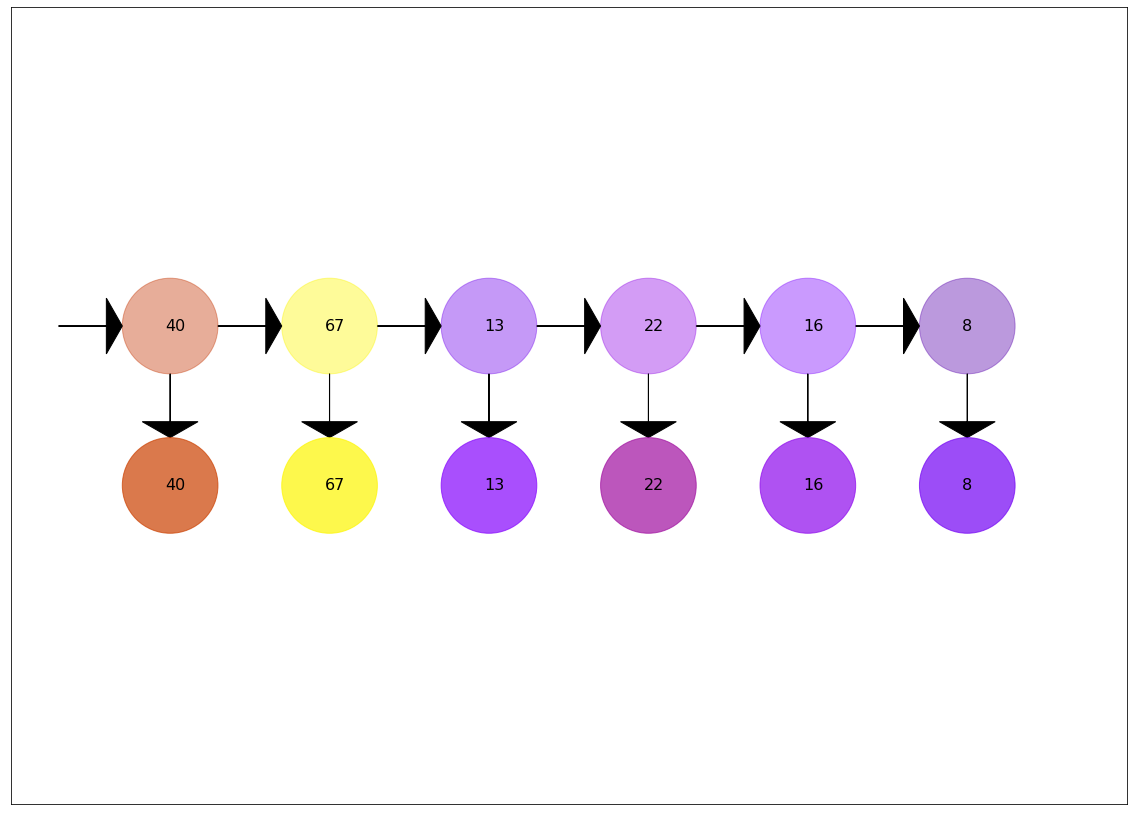

['----', '0---', '+---', '+0--', '+-0-', '++00']


In [27]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pbrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating robot overtakes left HMM

In [28]:
rotl_seqs = rotl_lab_seqs_train

In [29]:
rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
print(rotl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

[[23, 4, 22, 13, 22, 4, 13, 22, 4, 22, 4, 22, 4, 22, 4, 7, 25, 17, 69], [13, 4, 22, 4, 5, 22, 13, 3, 4], [77, 4, 22, 13, 23, 22, 13, 22, 4, 22, 13, 22, 4, 23, 21, 4, 22, 13, 4, 5, 4, 7, 25, 7, 61, 62, 80], [4, 22, 4, 22, 4, 22, 4, 5, 4, 22, 4, 22, 4, 5, 4, 7, 25, 26, 15, 78, 69, 71], [23, 4, 22, 13, 22, 4, 22, 13, 22, 4, 22, 4, 5, 4, 5, 4, 22, 4, 22, 4, 5, 4, 7, 8, 7, 25, 7, 8, 6, 8, 26, 71, 80, 71, 80, 71, 80], [4, 22, 13, 22, 4, 22, 13, 22, 4, 5, 23, 22, 4, 5, 4, 22, 4, 13, 22, 4, 22, 4, 5, 4, 7, 8, 7, 25], [13, 4, 5, 4, 22, 13, 22, 4, 22, 4, 5, 4, 22, 4, 13, 22, 4, 7, 26, 15, 69], [23, 5, 23, 14, 13, 22, 4, 22, 4, 22, 4, 22, 4, 5, 22, 4, 13, 22, 13, 22, 4, 7, 8, 26, 17, 69, 71], [23, 22, 4, 22, 13, 14, 22, 4, 13, 22, 4, 5, 4, 5, 13, 22, 4, 7, 25], [22, 4, 22, 13, 22, 4, 22, 4, 22, 4, 22, 4, 22, 4, 7, 22, 25, 26, 24, 78, 69], [23, 4, 22, 13, 22, 4, 22, 4, 23, 22, 4, 22, 4, 7, 16, 10, 9, 0, 7, 8, 7, 25, 16, 71, 80, 69], [23, 12, 21, 12, 14, 13, 22, 4, 22, 4, 22, 4, 22, 4, 22, 23, 22, 

[['+0-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++0-',
  '+00-',
  '+-00',
  '0-0+'],
 ['+---', '++--', '+0--', '++--', '++-0', '+0--', '+---', '++-+', '++--'],
 ['00-0',
  '++--',
  '+0--',
  '+---',
  '+0-0',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0-0',
  '+0-+',
  '++--',
  '+0--',
  '+---',
  '++--',
  '++-0',
  '++--',
  '++0-',
  '+00-',
  '++0-',
  '0+0-',
  '0+00',
  '0000'],
 ['++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '++0-',
  '+00-',
  '+000',
  '+-0+',
  '000+',
  '0-0+',
  '0-00'],
 ['+0-0',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '+---',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '++-0',
  '++--',
  '+0--',
  '++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '++0-',
  '++00',
  

In [30]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8

In [31]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotlHMM = hmms.DtHMM(A, B, Pi)

# Check rotlHMM params
A, B, Pi = rotlHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[4.19991600e-04 4.19991600e-04 4.19991600e-04 4.24191516e-02
 8.44183116e-02 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 1.68416632e-01 4.19991600e-04 4.24191516e-02
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.24191516e-02 4.24191516e-02 5.04409912e-01
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19991600e-04 4.19991600e-04 4.19991600e-04
 4.19991600e-04 4.19

In [32]:
A.min()

8.076892011953803e-05

In [33]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Left_Lab_Egs_Transitions", 0.0124)

Robot overtakes left HMM:


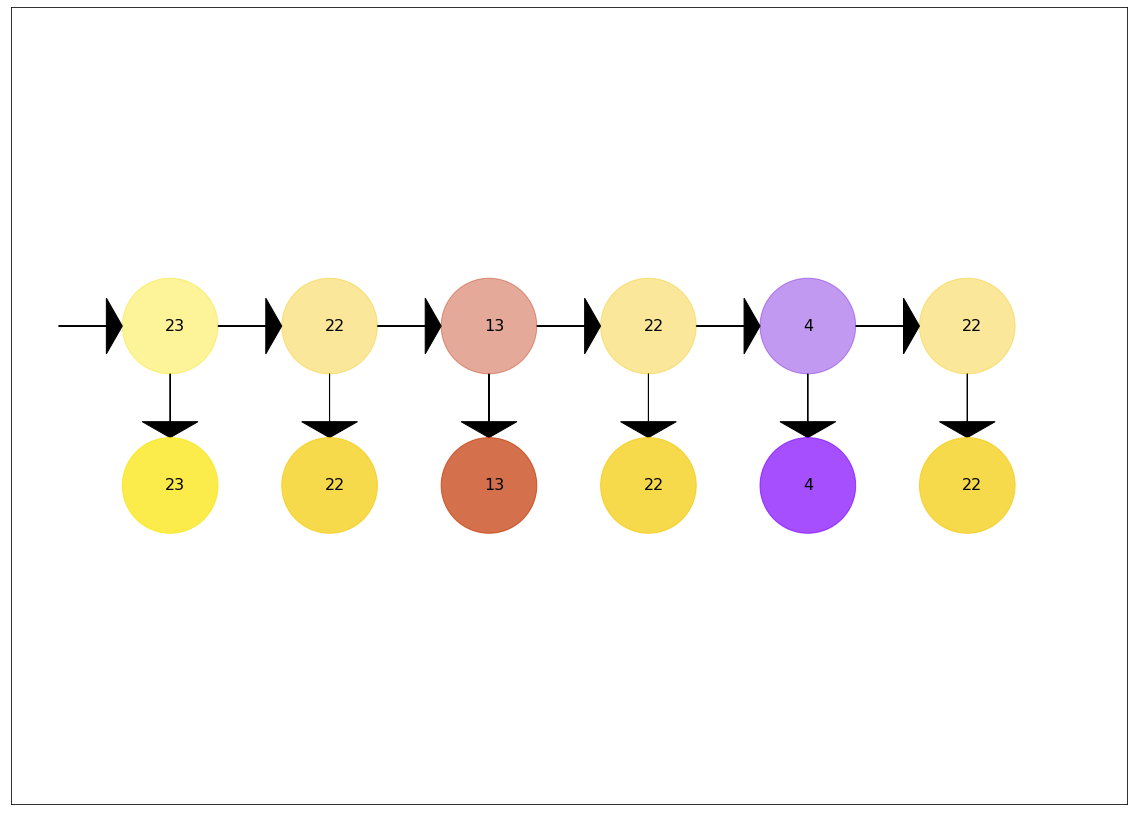

['+0-0', '+0--', '+---', '+0--', '++--', '+0--']


In [34]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotlHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating robot overtakes right HMM

In [35]:
rotr_seqs = rotr_lab_seqs_train

In [36]:
rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
print(rotr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

[[4, 22, 4, 5, 4, 5, 4, 5, 21, 5, 23, 22, 23, 26, 24, 26, 24, 78], [76, 77, 68, 77, 58, 4, 5, 4, 5, 4, 23, 5, 21, 23, 22, 4, 5, 8, 7], [23, 5, 3, 5, 4, 5, 3, 5, 12, 4, 3, 4, 13, 3, 13, 3, 13, 3, 13, 3, 13, 3, 13, 5, 23, 26, 8, 7, 8], [23, 22, 5, 3, 5, 3, 5, 3, 5, 3, 5, 4, 5, 3, 5, 3, 6, 8, 6, 24, 26], [12, 21, 23, 5, 3, 5, 3, 5, 3, 13, 4, 3, 13, 3, 13, 5, 3, 13, 3, 13, 3, 13, 3, 13, 4, 7, 8, 7, 25, 7, 25, 7], [21, 5, 3, 5, 3, 5, 3, 5, 3, 12, 13, 3, 4, 13, 3, 13, 3, 13, 5, 4, 7, 8, 6, 26], [15, 12, 5, 3], [23, 3, 5, 3, 5, 4, 5, 3, 5, 3, 5, 3, 5, 4, 7, 8, 6, 8, 26], [76, 58, 76, 4, 5, 3, 5, 4, 5, 4, 5, 3, 5, 4, 5, 8, 6, 8, 26, 17, 80], [77, 67, 76, 77, 4, 22, 4, 5, 4, 5, 4, 22, 4, 5, 3, 5, 3, 5, 8, 7, 25, 8, 26], [24, 20, 9, 15, 17, 6], [77, 13, 22, 4, 5, 4, 5, 3, 5, 3, 5, 4, 5, 4, 5, 4, 7, 8, 6, 26, 17, 71], [20, 1, 2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 1, 2, 20, 2, 20, 19, 2, 1, 7], [50, 40, 49, 58, 22, 4, 5, 4, 5, 4, 5, 3, 5, 23, 5, 3, 5, 4, 5, 3, 5, 8], [76, 58, 76, 67, 76,

[['++--',
  '+0--',
  '++--',
  '++-0',
  '++--',
  '++-0',
  '++--',
  '++-0',
  '+0-+',
  '++-0',
  '+0-0',
  '+0--',
  '+0-0',
  '+000',
  '+00+',
  '+000',
  '+00+',
  '000+'],
 ['00--',
  '00-0',
  '0--0',
  '00-0',
  '0+--',
  '++--',
  '++-0',
  '++--',
  '++-0',
  '++--',
  '+0-0',
  '++-0',
  '+0-+',
  '+0-0',
  '+0--',
  '++--',
  '++-0',
  '++00',
  '++0-'],
 ['+0-0',
  '++-0',
  '++-+',
  '++-0',
  '++--',
  '++-0',
  '++-+',
  '++-0',
  '+--+',
  '++--',
  '++-+',
  '++--',
  '+---',
  '++-+',
  '+---',
  '++-+',
  '+---',
  '++-+',
  '+---',
  '++-+',
  '+---',
  '++-+',
  '+---',
  '++-0',
  '+0-0',
  '+000',
  '++00',
  '++0-',
  '++00'],
 ['+0-0',
  '+0--',
  '++-0',
  '++-+',
  '++-0',
  '++-+',
  '++-0',
  '++-+',
  '++-0',
  '++-+',
  '++-0',
  '++--',
  '++-0',
  '++-+',
  '++-0',
  '++-+',
  '++0+',
  '++00',
  '++0+',
  '+00+',
  '+000'],
 ['+--+',
  '+0-+',
  '+0-0',
  '++-0',
  '++-+',
  '++-0',
  '++-+',
  '++-0',
  '++-+',
  '+---',
  '++--',
  '++-+',
  '+--

In [37]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
1

In [38]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotrHMM = hmms.DtHMM(A, B, Pi)

# Check rotrHMM params
A, B, Pi = rotrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00041999 0.04241915 0.00041999 0.00041999 0.08441831 0.00041999
 0.00041999 0.00041999 0.00041999 0.04241915 0.00041999 0.00041999
 0.04241915 0.00041999 0.00041999 0.04241915 0.00041999 0.00041999
 0.00041999 0.00041999 0.08441831 0.04241915 0.04241915 0.16841663
 0.04241915 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.04241915 0.04241915 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999 0.00041999
 0.00041999 0.00041999 0.00041999 0.00041999 0.12641747 0.12641747
 0.00041999 0.00041999 0.00041999]
1.0
A:
 [[2.07900208e-03 2.07900208e-03 6.25779626e-01 ... 2.07900208e-03
  2.07900208e-03

In [39]:
A.min()

0.00011388224575788635

In [40]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Right_Lab_Egs_Transitions", 0.0124)

Robot overtakes right HMM:


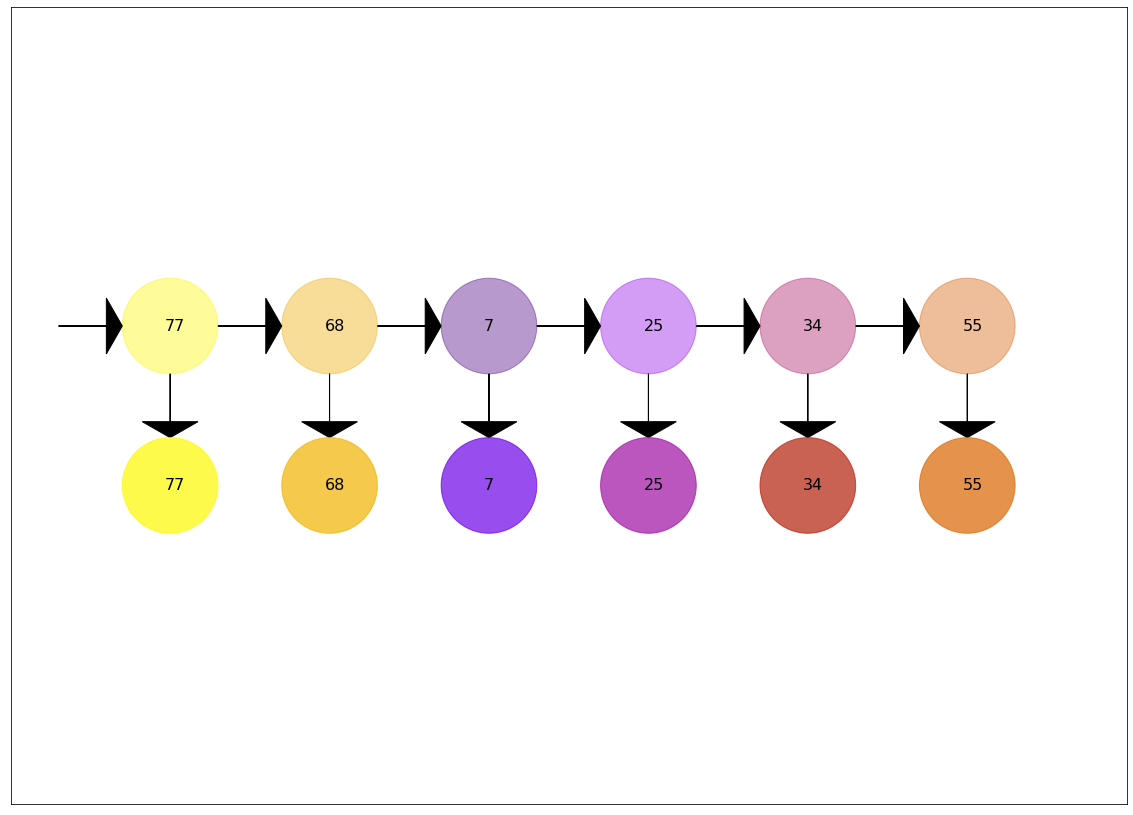

['00-0', '0--0', '++0-', '+00-', '-+0-', '0++-']


In [41]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating path-crossing HMM

In [42]:
pc_seqs = pc_lab_seqs_train

In [43]:
pc_seqs = [list(map(QTC_C_to_num, seq)) for seq in pc_seqs]
print(pc_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pc_seqs]

[[44, 42, 36, 37, 43, 37, 43, 37, 43, 40], [43, 52, 31, 58, 59, 58, 4, 13, 4, 13, 16], [44, 42, 44, 42, 38, 37, 43, 40], [42, 36, 37, 38, 37, 38, 37], [41, 39, 42, 39, 42, 36, 37, 40], [43, 34, 31], [46, 28, 34, 31, 32], [39, 41, 39, 41, 40, 13, 4, 5, 3], [38, 44, 43, 37, 38, 43, 37, 43, 37, 43], [44, 42, 43, 40], [34, 31, 40], [36, 38, 36, 37, 38, 37, 36], [52, 34, 31, 66, 58, 66, 58, 67, 57, 58, 4, 13, 12], [43, 52, 31, 58, 76, 58, 4], [41, 39, 40], [36, 38, 36, 38, 37, 43], [66, 68, 67, 13, 12], [40, 49, 31, 58, 4], [38, 36, 38, 37, 38, 36, 37, 38, 37, 38, 37, 38], [66, 68, 67, 13, 23], [43, 52, 34, 31, 32], [39, 41, 40, 67, 13], [67, 66, 68, 13, 22, 12, 21, 3, 23, 26, 80], [39, 41, 40, 67, 13], [42, 41, 44, 41, 40, 41, 40], [34, 31, 32, 31, 32], [36, 37, 38, 36, 38], [46, 28, 46, 37, 43, 52, 34, 31, 30, 31, 32, 31], [38, 36, 38, 36, 37, 38, 36, 38, 37], [37, 46, 28, 34, 31], [37, 43, 52, 34, 31, 30, 32, 31, 32], [66, 67, 68, 67, 13, 23, 26], [43, 34, 31, 39, 31, 58, 57], [52, 34, 3

[['--00',
  '--0+',
  '--++',
  '--+-',
  '--0-',
  '--+-',
  '--0-',
  '--+-',
  '--0-',
  '----'],
 ['--0-',
  '-00-',
  '-+--',
  '0+--',
  '0+-0',
  '0+--',
  '++--',
  '+---',
  '++--',
  '+---',
  '+-0-'],
 ['--00', '--0+', '--00', '--0+', '--+0', '--+-', '--0-', '----'],
 ['--0+', '--++', '--+-', '--+0', '--+-', '--+0', '--+-'],
 ['---0', '---+', '--0+', '---+', '--0+', '--++', '--+-', '----'],
 ['--0-', '-+0-', '-+--'],
 ['-0+-', '-++-', '-+0-', '-+--', '-+-0'],
 ['---+', '---0', '---+', '---0', '----', '+---', '++--', '++-0', '++-+'],
 ['--+0',
  '--00',
  '--0-',
  '--+-',
  '--+0',
  '--0-',
  '--+-',
  '--0-',
  '--+-',
  '--0-'],
 ['--00', '--0+', '--0-', '----'],
 ['-+0-', '-+--', '----'],
 ['--++', '--+0', '--++', '--+-', '--+0', '--+-', '--++'],
 ['-00-',
  '-+0-',
  '-+--',
  '0--+',
  '0+--',
  '0--+',
  '0+--',
  '0---',
  '0+-+',
  '0+--',
  '++--',
  '+---',
  '+--+'],
 ['--0-', '-00-', '-+--', '0+--', '00--', '0+--', '++--'],
 ['---0', '---+', '----'],
 ['--++', '

In [44]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pc_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
0
1
2
3
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
0
1
2
0
1
0
1
2
3
4
5
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
0
1
0
1
2
3
4
0
1
2
3
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
4
5
6
7
8
9
0
1
2
3
0
1
2
3
4
5
0
1
2
3
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
0
1
2
3
0
1
2
3
4
5
6
7
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
0
1
2
0
1
2
3
0
1
2
3
4
5
6
7
0
1
2
3
4
5
0
1
2
3
4
0
1
2
3
4
5
6
7
0
1
2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 

In [45]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pc_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pcHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pcHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.02157659 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.0643025  0.00021363
 0.0643025  0.0643025  0.0643025  0.10702841 0.04293954 0.04293954
 0.0643025  0.14975433 0.10702841 0.00021363 0.04293954 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.0643025  0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.0643025  0.02157659 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363 0.00021363
 0.00021363 0.00021363 0.00021363]
0.9999999999999999
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.0123

In [46]:
A.min()

0.0003471017007983339

In [47]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing HMM:


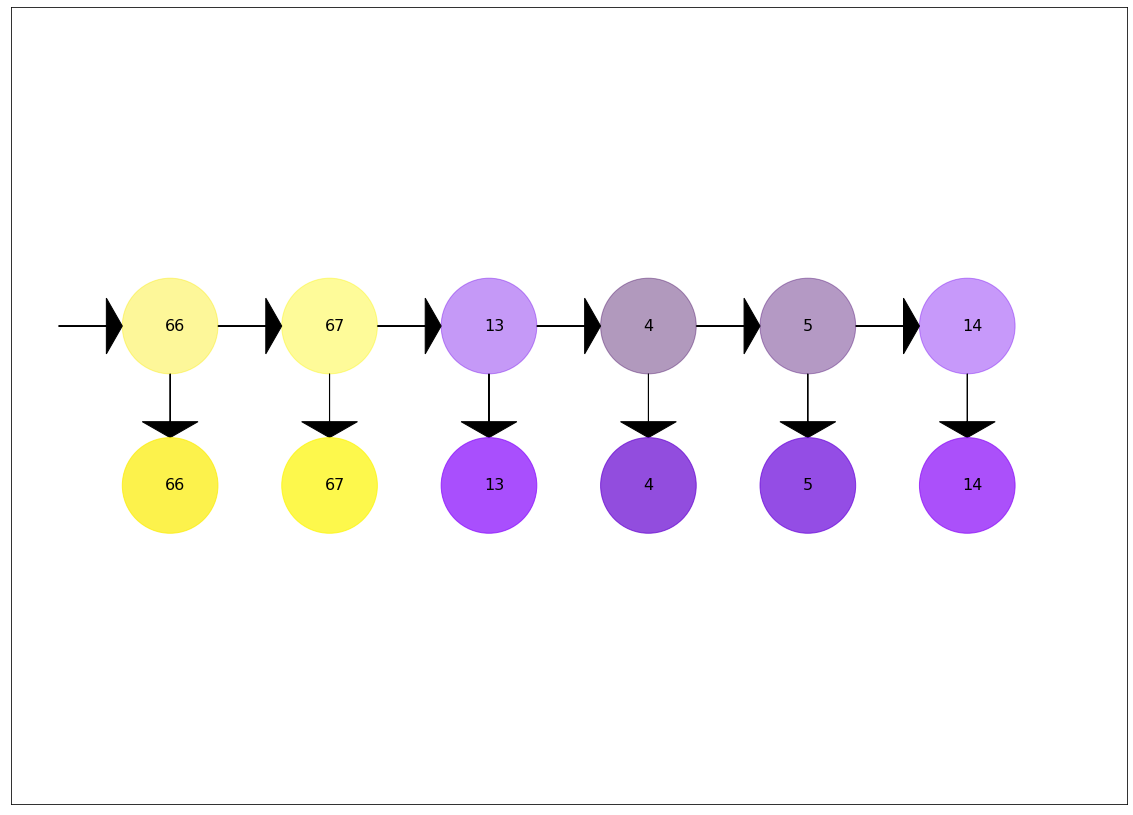

['0--+', '0---', '+---', '++--', '++-0', '+--0']


In [48]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pcHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating rejections HMM

In [49]:
u_seqs = u_lab_seqs_train

u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
print(u_seqs)
[list(map(num_to_QTC_C, seq)) for seq in u_seqs]

# Create HMM using uniform parameters as a baseline to compare against pass-by
A = np.ones((N_nodes, N_nodes))
print(A.shape)

if rejections_trained:
    # Give frequency based probs to e.g. transitions
    for seq in u_seqs:
        for i in range(0, len(seq) - 1):
            print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
if rejections_trained:
    for seq in u_seqs:
        Pi[seq[0]] += rejection_init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())


uniform_HMM = hmms.DtHMM(A, B, Pi)

# Check uniform_HMM params
A_uniform, B_uniform, Pi_uniform = uniform_HMM.params
print("A:\n", A_uniform)
for row in A_uniform:
    print(row.sum())
print("B:\n", B_uniform)
for row in B_uniform:
    print(row.sum())
print("Pi:\n", Pi_uniform)
print(Pi_uniform.sum())

[[17, 16, 17, 15, 12, 4], [80], [70, 79, 61, 60, 61], [50, 40, 49, 40, 49, 31, 58, 4, 5, 59, 77, 62, 80, 71, 80, 71, 80], [80], [9, 11, 9, 15, 12, 21], [16, 17, 9, 15, 12, 21, 3, 4], [52, 43, 40, 49, 31, 40, 49, 31, 58, 59, 4, 5, 59, 62, 80, 71], [70, 61, 79, 61], [71, 70, 61], [58, 76, 67, 13, 22, 4, 13, 22], [70, 61], [9, 15, 17, 15, 12, 21, 3, 4, 21], [15, 12], [80], [70, 79, 70, 79, 61, 69], [12, 23], [71, 70, 61, 69], [9, 11, 10, 11, 9, 15, 12, 3], [58, 76, 58, 76, 67, 13, 22, 13, 22, 4], [9, 15, 12, 21, 3], [70, 61], [80], [9, 15, 12, 13, 22, 7, 1, 10], [60, 62, 79, 70], [80], [15, 17, 15, 12, 21, 3, 4], [80], [79, 61, 69, 61], [70, 79, 70, 79, 61, 70, 71, 69, 78], [67, 76, 22, 13], [9, 15, 12, 4], [17, 16, 17, 15, 12, 15, 12, 23], [69, 71, 69, 70, 61], [52, 43, 40, 49, 31, 40, 49, 40, 49, 31, 58, 4, 5, 59, 80, 71, 80], [70, 61, 60, 61, 60, 61], [70, 79, 61], [67, 13, 22], [15, 12, 13, 12, 4, 7, 1, 10], [70, 69, 71, 69, 70, 61, 62, 60, 70], [12, 13, 12, 23], [70, 79, 61, 69, 61],

rejections HMM:


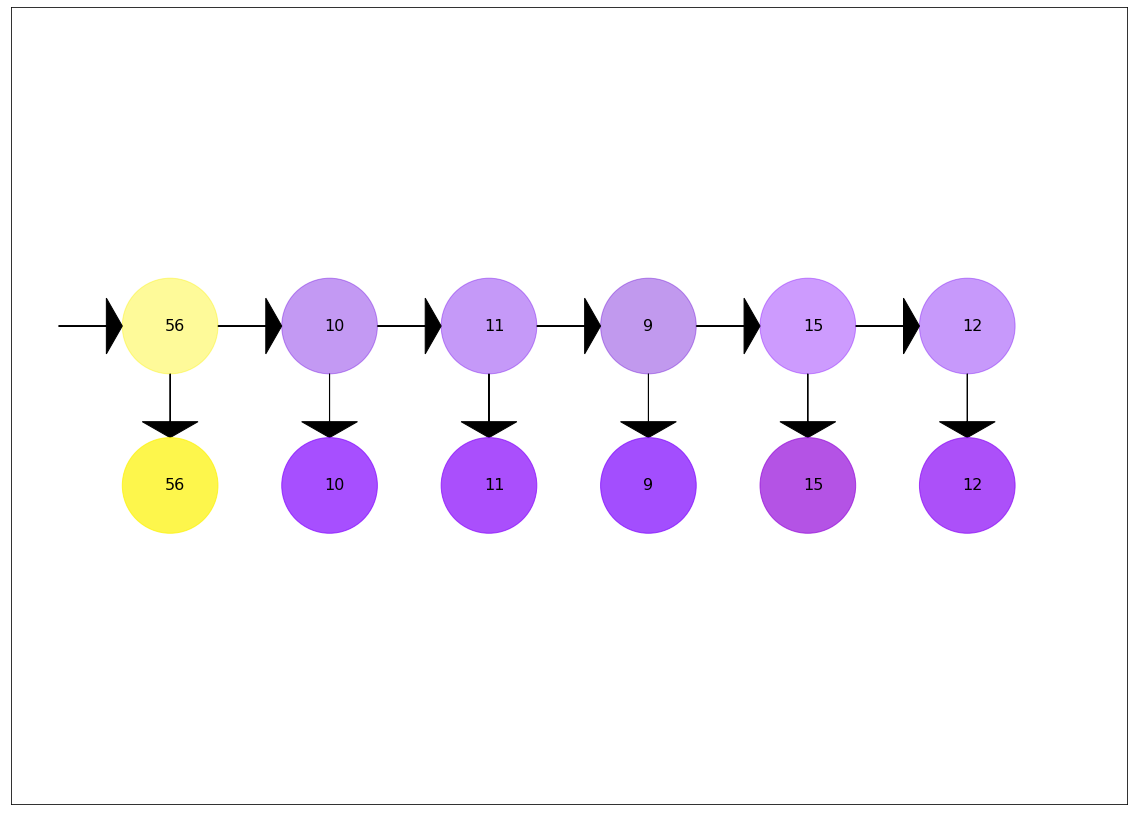

['0++0', '+-+-', '+-+0', '+-++', '+-0+', '+--+']


In [50]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = uniform_HMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("rejections HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Classifying HRI situation of QTC<sub>C</sub> sequences generated by rejections HMM

In [51]:
# Generate dataset of both hidden states and emissions sequences from uniform HMM
s_seqs, e_seqs = uniform_HMM.generate_data((len(pass_by_l_seqs), len(pass_by_l_seqs[0])))
e_seqs

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-149.75501047401605
The probability of the dataset being generated by the pass-by left model is: 9.166959524221423e-66 .
-150.43566067989852
The probability of the dataset being generated by the pass-by right model is: 4.641118799283408e-66 .
-93.286989519602
The probability of the dataset being generated by the rejection model is: 3.061788716791861e-41 .
-143.72558390719993
The probability of the dataset being generated by the robot overtaking left model is: 3.8086582106392187e-63 .
-143.72558390719993
The probability of the dataset being generated by the robot overtaking right model is: 3.8086582106392187e-63 .
-155.8675544654884
The probability of the dataset being generated by the path-crossing model is: 2.0303980510782677e-68 .
Classified as rejection


## Classifying HRI situation of example pass-by left QTC<sub>C</sub> sequences

In [52]:
pass_by_l_seqs = [np.array(seq) for seq in pass_by_l_seqs]

In [53]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_l_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-124.70527921104265
The probability of the dataset being generated by the pass-by left model is: 6.937218513577086e-55 .
-387.311173668267
The probability of the dataset being generated by the pass-by right model is: 6.207182242027823e-169 .
-426.46291615845206
The probability of the dataset being generated by the rejection model is: 6.1589797476124315e-186 .
-492.08643055712986
The probability of the dataset being generated by the robot overtaking left model is: 1.9479535181101878e-214 .
-479.42123541641564
The probability of the dataset being generated by the robot overtaking right model is: 6.16599192178039e-209 .
-448.3399111636581
The probability of the dataset being generated by the path-crossing model is: 1.9429005205299693e-195 .
Classified as pass-by left


## Classifying HRI situation of example pass-by right QTC<sub>C</sub> sequences

In [54]:
pass_by_r_seqs = [np.array(seq) for seq in pass_by_r_seqs]

In [55]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_r_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-777.4104350408727
The probability of the dataset being generated by the pass-by left model is: 0.0 .
-210.82085694388905
The probability of the dataset being generated by the pass-by right model is: 2.764809156854568e-92 .
-751.2598992048113
The probability of the dataset being generated by the rejection model is: 0.0 .
-772.7006538609635
The probability of the dataset being generated by the robot overtaking left model is: 0.0 .
-673.4088345682509
The probability of the dataset being generated by the robot overtaking right model is: 3.485451806534468e-293 .
-667.9306335796014
The probability of the dataset being generated by the path-crossing model is: 8.344715645232335e-291 .
Classified as pass-by right


## Classifying HRI situation of example robot overtaking left QTC<sub>C</sub> sequences

In [56]:
rotl_seqs = [np.array(seq) for seq in rotl_seqs]

In [57]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotl_seqs)

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-1898.7323627394678
The probability of the dataset being generated by the pass-by left model is: 0.0 .
-1688.3085572037917
The probability of the dataset being generated by the pass-by right model is: 0.0 .
-1707.8326836294598
The probability of the dataset being generated by the rejection model is: 0.0 .
-555.606139801557
The probability of the dataset being generated by the robot overtaking left model is: 5.050325532051453e-242 .
-1128.7721174201843
The probability of the dataset being generated by the robot overtaking right model is: 0.0 .
-2217.6997001486216
The probability of the dataset being generated by the path-crossing model is: 0.0 .
Classified as robot overtaking left


## Classifying HRI situation of example robot overtaking right QTC<sub>C</sub> sequences

In [58]:
rotr_seqs = [np.array(seq) for seq in rotr_seqs]

In [59]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotr_seqs)

# print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

-2094.325541327911
The probability of the dataset being generated by the pass-by left model is: 0.0 .
-1521.2158159288506
The probability of the dataset being generated by the pass-by right model is: 0.0 .
-1942.173974223175
The probability of the dataset being generated by the rejection model is: 0.0 .
-1370.3959603393882
The probability of the dataset being generated by the robot overtaking left model is: 0.0 .
-565.910954500541
The probability of the dataset being generated by the robot overtaking right model is: 1.6904222942823737e-246 .
-1862.1568408161763
The probability of the dataset being generated by the path-crossing model is: 0.0 .
Classified as robot overtaking right


## Classifying HRI situation of example path-crossing QTC<sub>C</sub> sequences

In [60]:
pc_seqs = [np.array(seq) for seq in pc_seqs]

In [61]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pc_seqs)

print(s_seqs)

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

[[70]
 [ 9]
 [70]
 [70]
 [ 0]
 [21]
 [ 6]
 [22]
 [70]
 [17]
 [53]
 [57]
 [48]
 [52]
 [70]
 [ 7]
 [67]
 [ 3]
 [47]
 [29]
 [15]
 [33]
 [ 0]]
-1463.140570756641
The probability of the dataset being generated by the pass-by left model is: 0.0 .
-1437.1843057999663
The probability of the dataset being generated by the pass-by right model is: 0.0 .
-1351.1367864601923
The probability of the dataset being generated by the rejection model is: 0.0 .
-1578.4930470736763
The probability of the dataset being generated by the robot overtaking left model is: 0.0 .
-1541.9037270568176
The probability of the dataset being generated by the robot overtaking right model is: 0.0 .
-452.47432309360624
The probability of the dataset being generated by the path-crossing model is: 3.1109875818624337e-197 .
Classified as path-crossing


## Classifying HRI situation of individual lab QTC<sub>C</sub> sequences

In [62]:
# Get hidden states and emissions sequences from observed sequences
sequence_no = 5
symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_lab_seqs[i]] for i in range(len(u_lab_seqs))]
e_seqs = np.array([symbol_seqs[sequence_no]])

print(list(map(num_to_QTC_C, s_seqs[0])))

ll_pb_l = pblHMM.data_estimate(e_seqs)
print(ll_pb_l)
prob_pb_l = np.exp(ll_pb_l)

print("The probability of the dataset being generated by the pass-by left model is:", \
      prob_pb_l, ".")

ll_pb_r = pbrHMM.data_estimate(e_seqs)
print(ll_pb_r)
prob_pb_r = np.exp(ll_pb_r)

print("The probability of the dataset being generated by the pass-by right model is:", \
      prob_pb_r, ".")

ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
print(ll_uniform)
prob_uniform = np.exp(ll_uniform)

print("The probability of the dataset being generated by the rejection model is:", \
      prob_uniform, ".")

ll_rotl = rotlHMM.data_estimate(e_seqs)
print(ll_rotl)
prob_rotl = np.exp(ll_rotl)

print("The probability of the dataset being generated by the robot overtaking left model is:", \
      prob_rotl, ".")

ll_rotr = rotrHMM.data_estimate(e_seqs)
print(ll_rotr)
prob_rotr = np.exp(ll_rotr)

print("The probability of the dataset being generated by the robot overtaking right model is:", \
      prob_rotr, ".")

ll_pc = pcHMM.data_estimate(e_seqs)
print(ll_pc)
prob_pc = np.exp(ll_pc)

print("The probability of the dataset being generated by the path-crossing model is:", \
      prob_pc, ".")

classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
print("Classified as", classes[class_id])

['0-0-']
-6.891610341928784
The probability of the dataset being generated by the pass-by left model is: 0.001016275970776881 .
-6.891610341928784
The probability of the dataset being generated by the pass-by right model is: 0.001016275970776881 .
-4.9769417312149775
The probability of the dataset being generated by the rejection model is: 0.0068951174678190804 .
-6.891610341928784
The probability of the dataset being generated by the robot overtaking left model is: 0.001016275970776881 .
-6.891610341928784
The probability of the dataset being generated by the robot overtaking right model is: 0.001016275970776881 .
-7.105923283793274
The probability of the dataset being generated by the path-crossing model is: 0.0008202320386326662 .
Classified as rejection


## K-fold CV of Classifying HRSI situation of all lab QTC<sub>C</sub> sequences

In [63]:
rotl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotl_lab_seqs):
    rotl_splits.append([train_index, test_index])
    
rotl_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 15, 17, 18, 20, 21, 22, 23, 24,
         25, 27, 29, 31, 33, 34]),
  array([ 0,  1,  9, 12, 13, 14, 16, 19, 26, 28, 30, 32])],
 [array([ 0,  1,  2,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 26,
         28, 29, 30, 31, 32, 33]),
  array([ 3,  4,  5,  6, 10, 20, 21, 23, 24, 25, 27, 34])],
 [array([ 0,  1,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 19, 20, 21, 23, 24,
         25, 26, 27, 28, 30, 32, 34]),
  array([ 2,  7,  8, 11, 15, 17, 18, 22, 29, 31, 33])]]

In [64]:
rotr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotr_lab_seqs):
    rotr_splits.append([train_index, test_index])
    
rotr_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 15, 17, 18, 20, 21, 22, 23, 24,
         25, 27, 29, 31, 33, 34]),
  array([ 0,  1,  9, 12, 13, 14, 16, 19, 26, 28, 30, 32])],
 [array([ 0,  1,  2,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 26,
         28, 29, 30, 31, 32, 33]),
  array([ 3,  4,  5,  6, 10, 20, 21, 23, 24, 25, 27, 34])],
 [array([ 0,  1,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 19, 20, 21, 23, 24,
         25, 26, 27, 28, 30, 32, 34]),
  array([ 2,  7,  8, 11, 15, 17, 18, 22, 29, 31, 33])]]

In [65]:
pbl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_l_lab_seqs):
    pbl_splits.append([train_index, test_index])
    
pbl_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 15, 17, 18, 20, 21, 22, 23, 24,
         25, 27, 29, 31, 33, 34]),
  array([ 0,  1,  9, 12, 13, 14, 16, 19, 26, 28, 30, 32])],
 [array([ 0,  1,  2,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 26,
         28, 29, 30, 31, 32, 33]),
  array([ 3,  4,  5,  6, 10, 20, 21, 23, 24, 25, 27, 34])],
 [array([ 0,  1,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 19, 20, 21, 23, 24,
         25, 26, 27, 28, 30, 32, 34]),
  array([ 2,  7,  8, 11, 15, 17, 18, 22, 29, 31, 33])]]

In [66]:
pbr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_r_lab_seqs):
    pbr_splits.append([train_index, test_index])
    
pbr_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 15, 17, 18, 20, 21, 22, 23, 24,
         25, 27, 29, 31, 33, 34]),
  array([ 0,  1,  9, 12, 13, 14, 16, 19, 26, 28, 30, 32])],
 [array([ 0,  1,  2,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 26,
         28, 29, 30, 31, 32, 33]),
  array([ 3,  4,  5,  6, 10, 20, 21, 23, 24, 25, 27, 34])],
 [array([ 0,  1,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 19, 20, 21, 23, 24,
         25, 26, 27, 28, 30, 32, 34]),
  array([ 2,  7,  8, 11, 15, 17, 18, 22, 29, 31, 33])]]

In [67]:
pc_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pc_lab_seqs):
    pc_splits.append([train_index, test_index])
    
pc_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 24, 26, 31, 33, 34, 37, 38, 39, 40, 42, 43, 46, 47, 49, 50,
         51, 52, 53, 55, 57, 58, 62, 63, 65, 66, 68, 69]),
  array([ 0,  1,  9, 10, 23, 25, 27, 28, 29, 30, 32, 35, 36, 41, 44, 45, 48,
         54, 56, 59, 60, 61, 64, 67])],
 [array([ 0,  1,  3,  4,  7,  9, 10, 11, 15, 20, 21, 22, 23, 25, 26, 27, 28,
         29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47,
         48, 49, 52, 53, 54, 56, 59, 60, 61, 62, 64, 66, 67]),
  array([ 2,  5,  6,  8, 12, 13, 14, 16, 17, 18, 19, 24, 33, 46, 50, 51, 55,
         57, 58, 63, 65, 68, 69])],
 [array([ 0,  1,  2,  5,  6,  8,  9, 10, 12, 13, 14, 16, 17, 18, 19, 23, 24,
         25, 27, 28, 29, 30, 32, 33, 35, 36, 41, 44, 45, 46, 48, 50, 51, 54,
         55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 69]),
  array([ 3,  4,  7, 11, 15, 20, 21, 22, 26, 31, 34, 37, 38, 39, 40, 42, 43,
         47, 49, 52, 53, 62, 66])]]

In [68]:
u_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(u_lab_seqs):
    u_splits.append([train_index, test_index])
    
u_splits

[[array([  4,   6,   7,   8,   9,  10,  12,  15,  17,  19,  20,  22,  26,
          31,  32,  33,  34,  37,  38,  39,  40,  41,  42,  43,  45,  46,
          47,  48,  49,  50,  51,  52,  53,  54,  55,  57,  58,  60,  62,
          63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  75,  76,
          78,  80,  82,  85,  86,  87,  88,  90,  91,  93,  95,  96,  98,
          99, 100, 101, 103, 104]),
  array([  0,   1,   2,   3,   5,  11,  13,  14,  16,  18,  21,  23,  24,
          25,  27,  28,  29,  30,  35,  36,  44,  56,  59,  61,  74,  77,
          79,  81,  83,  84,  89,  92,  94,  97, 102])],
 [array([  0,   1,   2,   3,   4,   5,   7,  11,  13,  14,  15,  16,  18,
          20,  21,  22,  23,  24,  25,  27,  28,  29,  30,  31,  33,  34,
          35,  36,  37,  38,  39,  40,  42,  43,  44,  46,  47,  49,  50,
          51,  52,  56,  58,  59,  61,  63,  66,  67,  68,  69,  70,  72,
          74,  75,  77,  79,  81,  82,  83,  84,  85,  86,  89,  90,  92,
          93,  94, 

In [69]:
overall_accs = []
rotl_accs = []
rotr_accs = []
pbl_accs = []
pbr_accs = []
pc_accs = []
u_accs = []

y_true = []
y_pred = []

for k in range(K):    
    rotl_lab_seqs_train = np.array(rotl_lab_seqs)[rotl_splits[k][0]]
    rotl_lab_seqs_val = np.array(rotl_lab_seqs)[rotl_splits[k][1]]
    
    rotr_lab_seqs_train = np.array(rotr_lab_seqs)[rotr_splits[k][0]]
    rotr_lab_seqs_val = np.array(rotr_lab_seqs)[rotr_splits[k][1]]
    
    pb_l_lab_seqs_train = np.array(pb_l_lab_seqs)[pbl_splits[k][0]]
    pb_l_lab_seqs_val = np.array(pb_l_lab_seqs)[pbl_splits[k][1]]
    
    pb_r_lab_seqs_train = np.array(pb_r_lab_seqs)[pbr_splits[k][0]]
    pb_r_lab_seqs_val = np.array(pb_r_lab_seqs)[pbr_splits[k][1]]
    
    pc_lab_seqs_train = np.array(pc_lab_seqs)[pc_splits[k][0]]
    pc_lab_seqs_val = np.array(pc_lab_seqs)[pc_splits[k][1]]
    
    u_lab_seqs_train = np.array(u_lab_seqs)[u_splits[k][0]]
    u_lab_seqs_val = np.array(u_lab_seqs)[u_splits[k][1]]
    
#     rotl_lab_seqs_train, rotl_lab_seqs_val = train_test_split(rotl_lab_seqs, 
#         test_size=val_size,
#         random_state=random_state)

#     rotr_lab_seqs_train, rotr_lab_seqs_val = train_test_split(rotr_lab_seqs, 
#         test_size=val_size,
#         random_state=random_state)

#     pb_l_lab_seqs_train, pb_l_lab_seqs_val = train_test_split(pb_l_lab_seqs, 
#         test_size=val_size,
#         random_state=random_state)

#     pb_r_lab_seqs_train, pb_r_lab_seqs_val = train_test_split(pb_r_lab_seqs, 
#         test_size=val_size,
#         random_state=random_state)

#     pc_lab_seqs_train, pc_lab_seqs_val = train_test_split(pc_lab_seqs, 
#         test_size=val_size,
#         random_state=random_state)

#     u_lab_seqs_train, u_lab_seqs_val = train_test_split(u_lab_seqs, test_size=val_size, random_state=random_state)

#     for seq in u_lab_seqs_no_train:
#         u_lab_seqs_val.append(seq)
        
        
    ## Re-build models from training data
    ## Creating pass-by left HMM

    pass_by_l_seqs = pb_l_lab_seqs_train

    pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
#     print(pass_by_l_seqs)
#     [list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_l_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_l_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pblHMM = hmms.DtHMM(A, B, Pi)

    # Check pblHMM params
    A, B, Pi = pblHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

#     pass_by_l_seqs = tuple(pass_by_l_seqs)
    pass_by_l_seqs = [np.asarray(seq) for seq in pass_by_l_seqs]
    pass_by_l_seqs = np.asarray(pass_by_l_seqs)
#     print(pass_by_l_seqs)
#     pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]

    ## Creating pass-by right HMM

    pass_by_r_seqs = pb_r_lab_seqs_train

    pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
#     print(pass_by_r_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_r_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_r_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pbrHMM = hmms.DtHMM(A, B, Pi)

    # Check pbrHMM params
    A, B, Pi = pbrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes left HMM

    rotl_seqs = rotl_lab_seqs_train

    rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
#     print(rotl_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotl_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotl_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotlHMM = hmms.DtHMM(A, B, Pi)

    # Check rotlHMM params
    A, B, Pi = rotlHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes right HMM

    rotr_seqs = rotr_lab_seqs_train

    rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
#     print(rotr_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotr_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotr_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotrHMM = hmms.DtHMM(A, B, Pi)

    # Check rotrHMM params
    A, B, Pi = rotrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating path-crossing HMM

    pc_seqs = pc_lab_seqs_train

    pc_seqs = [list(map(QTC_C_to_num, seq)) for seq in pc_seqs]
#     print(pc_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pc_seqs]

    # Create transition matrix from handwritten examples of path-crossing QTC_C sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pc_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pc_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the path-crossing e.g. parameters
    pcHMM = hmms.DtHMM(A, B, Pi)

    # Check pcHMM params
    A, B, Pi = pcHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating rejections HMM

    u_seqs = u_lab_seqs_train

    u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
#     print(u_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in u_seqs]

    # Create HMM using uniform parameters as a baseline to compare against pass-by
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    if rejections_trained:
        # Give frequency based probs to e.g. transitions
        for seq in u_seqs:
            for i in range(0, len(seq) - 1):
#                 print(i)
                A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    if rejections_trained:
        for seq in u_seqs:
            Pi[seq[0]] += rejection_init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    uniform_HMM = hmms.DtHMM(A, B, Pi)

    # Check uniform_HMM params
    A_uniform, B_uniform, Pi_uniform = uniform_HMM.params
#     print("A:\n", A_uniform)
#     for row in A_uniform:
#         print(row.sum())
#     print("B:\n", B_uniform)
#     for row in B_uniform:
#         print(row.sum())
#     print("Pi:\n", Pi_uniform)
#     print(Pi_uniform.sum())

#     if rejections_trained:
#         u_seqs = [np.asarray(seq) for seq in u_seqs]
#         u_seqs = np.asarray(u_seqs)
#         uniform_HMM.baum_welch(u_seqs, bw_epochs)
        
    
    
    # Get correct count and accuracy of pass-by left classifications
    pb_l_correct = 0
    for pb_l_seq in pb_l_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_l_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs)
    #     print(ll_pb_l)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_l, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs)
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs)
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs)
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
        print("Classified as", classes[class_id])

        correct_class_id = 0
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        if class_id == correct_class_id:
            pb_l_correct += 1
            
        pb_l_acc = pb_l_correct/len(pb_l_lab_seqs_val)*100
    print("Pass-by left classifications are " + str(pb_l_acc) + "% accurate\n" )

    # Get correct count and accuracy of pass-by classifications
    pb_r_correct = 0
    for pb_r_seq in pb_r_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_r_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs)
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs)
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs)
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
        print("Classified as", classes[class_id])

        correct_class_id = 1
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        if class_id == correct_class_id:
            pb_r_correct += 1
            
        pb_r_acc = (pb_r_correct/len(pb_r_lab_seqs_val))*100
    print("Pass-by right classifications are " + str(pb_r_acc) + "% accurate\n" )

    # Get correct count and accuracy of robot overtaking left classifications
    rotl_correct = 0
    for rotl_seq in rotl_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotl_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs)
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs)
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs)
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
        print("Classified as", classes[class_id])

        correct_class_id = 2
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        if class_id == correct_class_id:
            rotl_correct += 1
            
        rotl_acc = (rotl_correct/len(rotl_lab_seqs_val))*100
    print("Robot overtaking left classifications are " + str(rotl_acc) + "% accurate\n" )

    # Get correct count and accuracy of robot overtaking right classifications
    rotr_correct = 0
    for rotr_seq in rotr_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotr_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs)
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs)
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs)
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
        print("Classified as", classes[class_id])

        correct_class_id = 3
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        if class_id == correct_class_id:
            rotr_correct += 1
            
        rotr_acc = (rotr_correct/len(rotr_lab_seqs_val))*100
    print("Robot overtaking right classifications are " + str(rotr_acc) + "% accurate\n" )

    # Get correct count and accuracy of path-crossing classifications
    pcs_correct = 0
    for pc_seq in pc_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pc_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs)
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs)
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs)
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
        print("Classified as", classes[class_id])

        correct_class_id = 4
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        if class_id == correct_class_id:
            pcs_correct += 1
            
        pc_acc = (pcs_correct/len(pc_lab_seqs_val))*100
    print("Path-crossing classifications are " + str(pc_acc) + "% accurate\n" )

    # Get correct count and accuracy of rejections
    us_correct = 0
    for u_seq in u_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq]]
        e_seqs = np.array(symbol_seqs)

        ll_pb_l = pblHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_l = np.exp(ll_pb_l)

    #     print("The probability of the dataset being generated by the pass-by left model is:", \
    #           prob_pb_r, ".")

        ll_pb_r = pbrHMM.data_estimate(e_seqs)
    #     print(ll_pb_r)
        prob_pb_r = np.exp(ll_pb_r)

    #     print("The probability of the dataset being generated by the pass-by right model is:", \
    #           prob_pb_r, ".")

        ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
    #     print(ll_uniform)
        prob_uniform = np.exp(ll_uniform)

    #     print("The probability of the dataset being generated by the rejection model is:", \
    #           prob_uniform, ".")

        ll_rotl = rotlHMM.data_estimate(e_seqs)
    #     print(ll_rotl)
        prob_rotl = np.exp(ll_rotl)

    #     print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #           prob_rotl, ".")

        ll_rotr = rotrHMM.data_estimate(e_seqs)
    #     print(ll_rotr)
        prob_rotr = np.exp(ll_rotr)

    #     print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #           prob_rotr, ".")

        ll_pc = pcHMM.data_estimate(e_seqs)
    #     print(ll_pc)
        prob_pc = np.exp(ll_pc)

    #     print("The probability of the dataset being generated by the path-crossing model is:", \
    #           prob_pc, ".")

        classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
        class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
        print("Classified as", classes[class_id])

        correct_class_id = 5
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        if class_id == correct_class_id:
            us_correct += 1
    
    # Rejections recall
    rTPs = us_correct
    rFNs = len(u_lab_seqs_val) - us_correct
    # rFPs = 0 # As accuracy in all other classes is 100%
    recall = rTPs / (rTPs + rFNs)
    # precision = rTPs / (rTPs + rFPs)
    
    u_acc = us_correct/len(u_lab_seqs_val)*100
    
    print("Rejection classifications are " + str(u_acc) + "% accurate\n" )

#     print("Rejections FN rate: " + str((rFNs/len(u_lab_seqs_val)*100)) + "%")
#     print("Rejections accuracy: " + str(u_acc) + "%" )
#     print("Rejection recall:", str(recall * 100) + "%")
    # print("Rejection precision:", str(precision * 100) + "%")

    total = len(pb_l_lab_seqs_val) + len(pb_r_lab_seqs_val) + len(rotl_lab_seqs_val) + len(rotl_lab_seqs_val) + len(pc_lab_seqs_val)
    total_correct = pb_l_correct + pb_r_correct + rotr_correct + rotl_correct + pcs_correct

    overall_acc = (total_correct/total)*100
    print("k", k+1, "/", K)
    print("\nOverall accuracy (excluding rejections): " + str(overall_acc) + "%")
    print("Robot overtaking left TPR: " + str(np.mean(rotl_acc)) + "%")
    print("Robot overtaking right TPR: " + str(np.mean(rotr_acc)) + "%")
    print("Pass-by left TPR: " + str(np.mean(pb_l_acc)) + "%")
    print("Pass-by right TPR: " + str(np.mean(pb_r_acc)) + "%")
    print("Path-crossing TPR: " + str(np.mean(pc_acc)) + "%")
    print("Rejection TPR: " + str(np.mean(u_acc)) + "%\n")
    
    overall_accs.append(overall_acc)
    rotl_accs.append(rotl_acc)
    rotr_accs.append(rotr_acc)
    pbl_accs.append(pb_l_acc)
    pbr_accs.append(pb_r_acc)
    pc_accs.append(pc_acc)
    u_accs.append(u_acc)

Classified as robot overtaking left
Classified as pass-by left
Classified as pass-by right
Classified as pass-by right
Classified as pass-by left
Classified as pass-by right
Classified as pass-by right
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Classified as pass-by left
Pass-by left classifications are 58.333333333333336% accurate

Classified as pass-by right
Classified as pass-by right
Classified as pass-by left
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Classified as pass-by right
Pass-by right classifications are 91.66666666666666% accurate

Classified as robot overtaking left
Classified as robot overtaking left
Classified as robot overtaking left
Classified as pass-by right
Classified as robot overtaking left
Classified as robot overtaking

Classified as rejection
Classified as robot overtaking right
Classified as robot overtaking right
Classified as robot overtaking right
Classified as robot overtaking right
Classified as robot overtaking right
Classified as robot overtaking right
Robot overtaking right classifications are 72.72727272727273% accurate

Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as pass-by right
Classified as rejection
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Classified as path-crossing
Path-crossing classifications are 91.30434

In [70]:
print("K-fold CV results:")
print("Overall accuracy: " + str(np.mean(overall_accs)) + "%")
print("Robot overtaking left TPR: " + str(np.mean(rotl_accs)) + "%")
print("Robot overtaking right TPR: " + str(np.mean(rotr_accs)) + "%")
print("Pass-by left TPR: " + str(np.mean(pbl_accs)) + "%")
print("Pass-by right TPR: " + str(np.mean(pbr_accs)) + "%")
print("Path-crossing TPR: " + str(np.mean(pc_accs)) + "%")
print("Rejection TPR: " + str(np.mean(u_accs)) + "%")


K-fold CV results:
Overall accuracy: 84.79599265020748%
Robot overtaking left TPR: 91.41414141414141%
Robot overtaking right TPR: 85.35353535353535%
Pass-by left TPR: 60.35353535353536%
Pass-by right TPR: 86.1111111111111%
Path-crossing TPR: 92.87439613526568%
Rejection TPR: 88.57142857142857%


In [71]:
cm = confusion_matrix(y_true, y_pred)

In [72]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

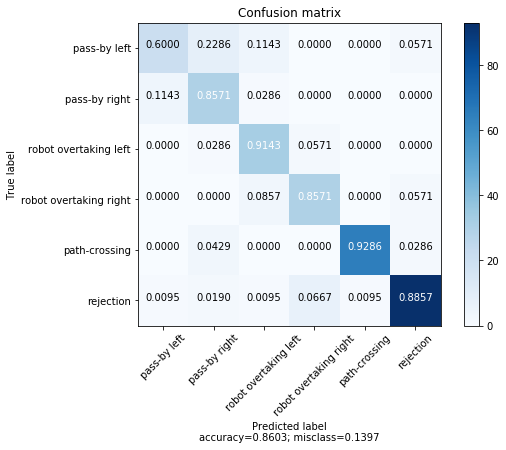

In [73]:
plot_confusion_matrix(cm, classes)